# Arabic Health Text Analysis

## Introduction

In this notebook, we explore the process of training and evaluating models for Arabic text data related to health topics using RNN, Bidirectional RNN, GRU, and LSTM architectures. The dataset consists of Arabic text collected from various websites on health-related topics, with relevance scores assigned to each text.


## Part 1: Data Collection and Preparation

### Dataset Preparation

- **Text:** Arabic text collected from various websites on health topics.
- **Score:** Relevance score of each text, ranging from 0 to 10.

### Data Collection

Utilized scraping libraries like BeautifulSoup to gather Arabic text data from multiple health-related websites.


In [10]:
from bs4 import BeautifulSoup
import requests
import warnings
import pandas as pd
import re

warnings.filterwarnings("ignore")

In [ ]:
texts = []

In [ ]:
url = "https://www.sante.gov.ma/sites/Ar/Pages/activites.aspx"
response = requests.get(url, verify=False)
soup = BeautifulSoup(response.content, "html.parser")
h3_elements = soup.select("#ctl00_ctl42_g_5c5a1f3c_eda6_4491_a25d_453a88e05f81 h3")
for h3 in h3_elements:
    texts.append(h3.text.strip())

In [ ]:
print(texts)

['الأنشطة', 'وزير الصحة والحماية الاجتماعية يجري مباحثات مع مسؤولين عن المعهد الهندي للأمصال', 'وزير الصحة والحماية الاجتماعية يستعرض في ندوة وطنية معالم إصلاح المنظومة الصحية الوطنية بين الماضي والحاضر وتحديات المستقبل', 'تعزيز التعاون في مجال الصحة والحماية الاجتماعية محور مباحثات بين وزير الصحة والحماية الاجتماعية والمدير العام لمنظمة العمل الدولية', 'إعطاء انطلاقة خدمات 15 مؤسسة صحية مع وحدة المستعجلات الطبية على مستوى جهة العيون الساقية الحمراء', 'إعطاء انطلاقة خدمات   14 مركزا للرعاية الصحية الأولية على مستوى جهة فاس- مكناس', 'تعزيز التعاون في مجال الصحة محور مباحثات بين وزير الصحة والحماية الاجتماعية ونظيره التشيكي', 'الحملة الوطنية للتشجيع على نمط العيش السليم "اختاروا الأفضل لصحتكم"', 'المصادقة على أول قانون يتعلق بمزاولة مهن التمريض', 'تخليد اليوم العالمي لمحاربة داء السل', 'الاحتفال باليوم العالمي للمهاجر']


In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

driver = webdriver.Chrome()

driver.get('https://www.who.int/ar/news')

def extract_headings():
    WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'p.heading.text-underline'))
    )
    headings_elements = driver.find_elements(By.CSS_SELECTOR, 'p.heading.text-underline')
    return [heading.text for heading in headings_elements]

all_headings = []
all_headings.extend(extract_headings())

def go_to_next_page():
    next_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, 'a[aria-label="Go to the next page"]'))
    )
    driver.execute_script("arguments[0].click();", next_button)

while True:
    try:
        go_to_next_page()
        WebDriverWait(driver, 10).until(
            EC.staleness_of(driver.find_element(By.CSS_SELECTOR, 'p.heading.text-underline'))
        )
        new_headings = extract_headings()
        if not new_headings:
            break
        all_headings.extend(new_headings)
    except Exception as e:
        print(f"Exception occurred: {e}")
        break

driver.quit()

In [ ]:
data = pd.DataFrame(all_headings + texts, columns = ['Texts'])
data.to_csv('scraping.csv', index = False)

In [ ]:
data = pd.read_csv('scraping.csv')
data

,Texts
0,"شعار ""الجميع من أجل الصحة، والصحة من أجل الجمي..."
1,تقرير جديد يشير إلى زيادة كبرى في عدوى الأمراض...
2,اعتماد أكبر عدد من الوكالات التنظيمية للمنتجات...
3,إحراز تقدم غير مسبوق في مفاوضات الدول الأعضاء ...
4,المنظّمة تحدّث قائمة أنواع البكتيريا المقاومة ...
...,...
1193,تعزيز التعاون في مجال الصحة محور مباحثات بين و...
1194,"الحملة الوطنية للتشجيع على نمط العيش السليم ""ا..."
1195,المصادقة على أول قانون يتعلق بمزاولة مهن التمريض
1196,تخليد اليوم العالمي لمحاربة داء السل


In [13]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
arabic_stop_words = list(stopwords.words('arabic'))

def preprocess_texts(texts):
    return texts.str.lower().str.replace(r'\W', ' ', regex=True)

In [ ]:
data['Texts'] = preprocess_texts(data['Texts'])
vectorizer = CountVectorizer(stop_words = arabic_stop_words)
dtm = vectorizer.fit_transform(data['Texts'])

In [ ]:
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda.fit(dtm)

topic_distribution = lda.transform(dtm)

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

print_top_words(lda, vectorizer.get_feature_names_out(), 5)

Topic #0:
بشأن الصحة العالمية 19 بيان
Topic #1:
الصحة العالمية بشأن منظمة رقم
Topic #2:
الصحة العالمية منظمة بشأن العالمي
Topic #3:
الصحة العالمية العالمي 19 كوفيد
Topic #4:
الصحة العالمية منظمة 19 كوفيد



In [ ]:
health_topic_index = 4

def calculate_scores(topic_distribution, topic_index):
    scores = topic_distribution[:, topic_index] * 10
    return scores

data['Scores'] = calculate_scores(topic_distribution, health_topic_index)

In [ ]:
threshold = 0.1
data = data[data['Scores'] > threshold]

In [5]:
data = pd.read_csv("scrapingScore.csv")
data.head(5)

,Texts,Scores
0,شعار الجميع من أجل الصحة والصحة من أجل الجمي...,0.157534
1,اعتماد أكبر عدد من الوكالات التنظيمية للمنتجات...,9.453587
2,إحراز تقدم غير مسبوق في مفاوضات الدول الأعضاء ...,0.168359
3,المنظ مة تحد ث قائمة أنواع البكتيريا المقاومة ...,0.156182
4,المنظ مة تختبر مسبقا صلاحية لقاح جديد لحم ى ا...,0.204761


## Part 2: Preprocessing Pipeline

### NLP Preprocessing Steps

- **Tokenization:** Splitting the text into tokens.
- **Stemming/Lemmatization:** Reducing words to their root form.
- **Stop Words Removal:** Eliminating common words.
- **Discretization:** Converting continuous scores to discrete values if needed.


In [ ]:
!pip install farasapy

In [19]:
from farasa.stemmer import FarasaStemmer
stemmer = FarasaStemmer()

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', ' ', text)
    text = text.lower()
    tokens = text.split()
    tokens = [token for token in tokens if token not in arabic_stop_words]
    cleaned_text = ' '.join(tokens)
    stemmed_text = stemmer.stem(cleaned_text)
    return stemmed_text


In [20]:
data['Texts'] = data['Texts'].apply(preprocess_text)
data['Texts'] = data['Texts'].apply(lambda x: x.split())

In [24]:
data

,Texts,Scores
0,"[شعار, جميع, صحة, صحة, جميع, مهد, طريق, جمعية,...",0.157534
1,"[اعتماد, أكبر, عدد, وكالة, تنظيمي, منتج, طب, ي...",9.453587
2,"[إحراز, تقدم, مسبوق, مفاوضة, دولة, عضو, شأن, ت...",0.168359
3,"[منظ, مة, تحدي, قائمة, نوع, بكتيريا, مقاومة, د...",0.156182
4,"[منظ, مة, اختبر, مسبق, صلاحية, لقاح, جديد, لحم...",0.204761
...,...,...
1125,"[تعزيز, تعاون, مجال, صحة, محور, مباحثة, وزير, ...",9.380450
1126,"[حملة, وطنية, تشجيع, نمط, عيش, سليم, اختار, أف...",0.201207
1127,"[مصادقة, قانون, تعلق, مزاولة, مهنة, تمريض]",0.289254
1128,"[تخليد, يوم, عالمي, محاربة, داء, سل]",0.286693


## Part 3: Model Training and Hyperparameter Tuning

### Architectures Explored

- **RNN (Recurrent Neural Network)**
- **Bidirectional RNN**
- **GRU (Gated Recurrent Unit)**
- **LSTM (Long Short-Term Memory)**

### Hyperparameter Tuning

Optimized model performance by adjusting hyperparameters such as learning rate, batch size, and epochs.


In [55]:
X = data['Texts']
y = data['Scores']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [57]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [58]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [59]:
max_sequence_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post')


In [60]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
num_classes = len(set(y_train))
num_epochs = 15
batch_size = 32

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, LSTM, Dense


In [62]:
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    tf.keras.layers.SimpleRNN(64),
    Dense(1)
])

bidirectional_rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    Bidirectional(tf.keras.layers.SimpleRNN(64)),
    Dense(1)
])

gru_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    GRU(64),
    Dense(1)
])

lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    LSTM(64),
    Dense(1)
])


In [63]:
for model in [rnn_model, bidirectional_rnn_model, gru_model, lstm_model]:
    model.compile(optimizer='adam', loss='mean_squared_error')


In [64]:
models = {"RNN": rnn_model, "Bidirectional RNN": bidirectional_rnn_model, "GRU": gru_model, "LSTM": lstm_model}
histories = {}
for name, model in models.items():
    history = model.fit(X_train_pad, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test_pad, y_test))
    histories[name] = history


Epoch 1/15
29/29 [==============================] - 8s 229ms/step - loss: 14.3215 - val_loss: 15.6754
Epoch 2/15
29/29 [==============================] - 4s 137ms/step - loss: 14.1239 - val_loss: 15.5337
Epoch 3/15
29/29 [==============================] - 3s 117ms/step - loss: 14.0042 - val_loss: 15.6174
Epoch 4/15
29/29 [==============================] - 5s 168ms/step - loss: 13.9991 - val_loss: 15.6556
Epoch 5/15
29/29 [==============================] - 3s 108ms/step - loss: 14.0129 - val_loss: 15.7282
Epoch 6/15
29/29 [==============================] - 3s 99ms/step - loss: 14.0777 - val_loss: 15.6526
Epoch 7/15
29/29 [==============================] - 3s 103ms/step - loss: 14.0394 - val_loss: 15.5865
Epoch 8/15
29/29 [==============================] - 4s 147ms/step - loss: 14.0217 - val_loss: 15.5368
Epoch 9/15
29/29 [==============================] - 3s 93ms/step - loss: 14.0851 - val_loss: 15.9370
Epoch 10/15
29/29 [==============================] - 3s 94ms/step - loss: 14.0441 - 

In [65]:
from sklearn.metrics import mean_squared_error

evaluation_results = {}
for name, model in models.items():
    test_loss = model.evaluate(X_test_pad, y_test)
    y_pred = model.predict(X_test_pad)
    mse = mean_squared_error(y_test, y_pred)
    evaluation_results[name] = {
        "test_loss": test_loss,
        "mse": mse
    }

    print(f"Results for {name}:")
    print("Test Loss:", test_loss)
    print("MSE:", mse)


8/8 [==============================] - 0s 10ms/step
Results for RNN:
Test Loss: 15.6061429977417
MSE: 15.606142492142535
8/8 [==============================] - 0s 16ms/step
Results for Bidirectional RNN:
Test Loss: 14.705493927001953
MSE: 14.705495150698932
8/8 [==============================] - 0s 4ms/step
Results for GRU:
Test Loss: 15.62416934967041
MSE: 15.624169783979577
8/8 [==============================] - 0s 4ms/step
Results for LSTM:
Test Loss: 15.677825927734375
MSE: 15.67782666510087


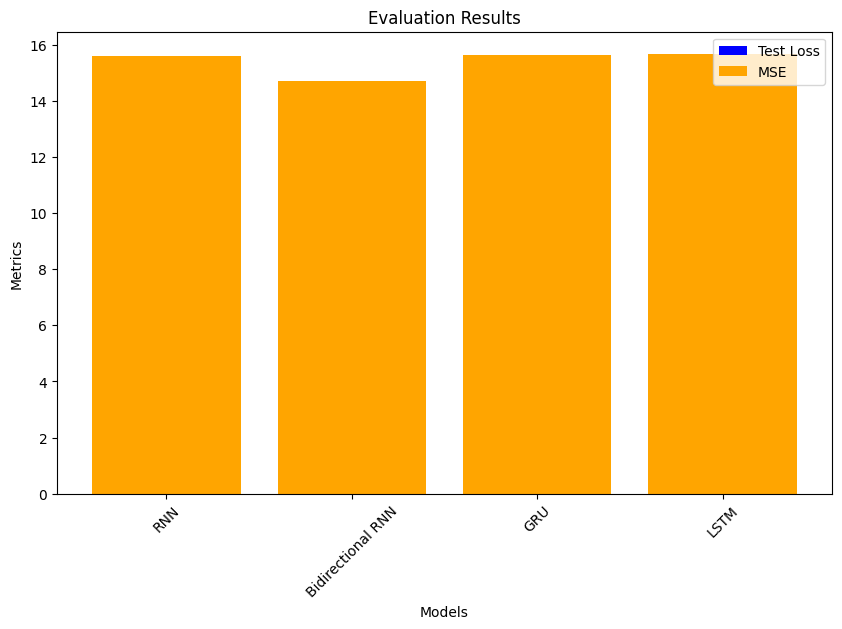

In [66]:
import matplotlib.pyplot as plt

model_names = list(evaluation_results.keys())
test_losses = [evaluation_results[name]["test_loss"] for name in model_names]
mses = [evaluation_results[name]["mse"] for name in model_names]

plt.figure(figsize=(10, 6))
plt.bar(model_names, test_losses, color='blue', label='Test Loss')
plt.bar(model_names, mses, color='orange', label='MSE')
plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Evaluation Results')
plt.legend()
plt.xticks(rotation=45)
plt.show()


## Part 4: Model Evaluation and Comparison

### Evaluation Metrics

- **Standard Metrics:** Loss function, accuracy.

### Results

| Model               | Test Loss | MSE     |
|---------------------|-----------|---------|
| RNN                 | 15.61     | 15.61   |
| Bidirectional RNN   | 14.71     | 14.71   |
| GRU                 | 15.62     | 15.62   |
| LSTM                | 15.68     | 15.68   |

### Conclusion

In conclusion, the models were trained and evaluated on Arabic text data related to health topics scraped from relevant websites. While the results provide insights into the performance of different architectures, it's essential to note that the observed loss scores may be influenced by several factors. These factors could include the methodology used to assign relevance scores to the texts, the adequacy of the dataset size, and the inherent complexities of the Arabic language in NLP tasks. Further improvements could be achieved by refining the preprocessing pipeline, expanding the dataset, and exploring advanced techniques tailored to Arabic health text analysis.
